In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.03,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(4,maxtasksperchild=1)

In [26]:
results=p.map(ff, range(1,40),chunksize=1)

5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 14.804288


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 9119 records out of 9119 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)


(9119, 242) (9119,) (9119,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37207	valid-rmse:2.38005


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.71759	valid-rmse:0.729458


6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


[100]	train-rmse:0.502463	valid-rmse:0.526545


(18,) 0.06769826 15.133374


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 9948 records out of 9948 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)


(9948, 242) (9948,) (9948,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36513	valid-rmse:2.3754


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


7


(1, 829, 517) (60, 829, 517)


[150]	train-rmse:0.477733	valid-rmse:0.510721


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 16.310143


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 10777 records out of 10777 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)


(10777, 242) (10777,) (10777,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38155	valid-rmse:2.38993


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.467983	valid-rmse:0.507792


[50]	train-rmse:0.717877	valid-rmse:0.729772


[250]	train-rmse:0.45993	valid-rmse:0.506638


8


(1, 829, 517) (60, 829, 517)


[100]	train-rmse:0.504292	valid-rmse:0.527679


72 (829, 517, 72) (829, 517)


[50]	train-rmse:0.717733	valid-rmse:0.728808


(18,) 0.06769826 17.574337


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[300]	train-rmse:0.452761	valid-rmse:0.505985


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 11606 records out of 11606 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)


(11606, 242) (11606,) (11606,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39487	valid-rmse:2.39906


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.44598	valid-rmse:0.505539


[150]	train-rmse:0.479577	valid-rmse:0.511911


[100]	train-rmse:0.500679	valid-rmse:0.524833


[400]	train-rmse:0.440082	valid-rmse:0.505283


[50]	train-rmse:0.720267	valid-rmse:0.730192


[200]	train-rmse:0.469283	valid-rmse:0.508953


[150]	train-rmse:0.476136	valid-rmse:0.50929


[450]	train-rmse:0.43476	valid-rmse:0.504936


[250]	train-rmse:0.461331	valid-rmse:0.507723


[100]	train-rmse:0.500852	valid-rmse:0.524715


[200]	train-rmse:0.466263	valid-rmse:0.506308


[500]	train-rmse:0.429055	valid-rmse:0.504695


[300]	train-rmse:0.45419	valid-rmse:0.506956


[150]	train-rmse:0.475234	valid-rmse:0.508357


[550]	train-rmse:0.423562	valid-rmse:0.504495


[350]	train-rmse:0.447556	valid-rmse:0.506431


[250]	train-rmse:0.458324	valid-rmse:0.505106


[200]	train-rmse:0.465119	valid-rmse:0.505262


[400]	train-rmse:0.44202	valid-rmse:0.50604


[600]	train-rmse:0.4184	valid-rmse:0.504428


[300]	train-rmse:0.451699	valid-rmse:0.504473


[650]	train-rmse:0.414035	valid-rmse:0.504327


[450]	train-rmse:0.436435	valid-rmse:0.505846


[250]	train-rmse:0.457075	valid-rmse:0.503928


[350]	train-rmse:0.445707	valid-rmse:0.504043


[700]	train-rmse:0.408883	valid-rmse:0.504225


[500]	train-rmse:0.431117	valid-rmse:0.505617


[300]	train-rmse:0.450176	valid-rmse:0.503161


[400]	train-rmse:0.439907	valid-rmse:0.503802


[550]	train-rmse:0.425917	valid-rmse:0.505532


[750]	train-rmse:0.40371	valid-rmse:0.50407


[350]	train-rmse:0.444247	valid-rmse:0.502635


[450]	train-rmse:0.434678	valid-rmse:0.503535


[600]	train-rmse:0.420976	valid-rmse:0.505447


[800]	train-rmse:0.399636	valid-rmse:0.504001


[400]	train-rmse:0.438868	valid-rmse:0.502359


[500]	train-rmse:0.429158	valid-rmse:0.503241


[650]	train-rmse:0.416563	valid-rmse:0.50533


Stopping. Best iteration:
[799]	train-rmse:0.399733	valid-rmse:0.503998



[450]	train-rmse:0.433592	valid-rmse:0.502037


0.15978658 0.25401437


[0.25401437]


-1 mean score 0.25401437


0.163361981511


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896091  0.033020  0.179410    7  2017-04-16
472     2.507290  2.529434 -0.022143  0.160093    1  2017-04-17
473     2.661330  2.644790  0.016539  0.169923    2  2017-04-18
474     2.754815  2.739582  0.015232  0.168439    3  2017-04-19
475     2.713762  2.724713 -0.010952  0.197753    4  2017-04-20
476     2.999000  2.978242  0.020758  0.127706    5  2017-04-21
477     3.075529  3.077967 -0.002438  0.140210    6  2017-04-22

0.163361981511


pred         y     error    error2  day        date
dayidx                                                         
471     2.896091  2.929110  0.033020  0.179410    7  2017-04-16
472     2.529434  2.507290 -0.022143  0.160093    1  2017-04-17
473     2.644790  2.661330  0.016539  0.169923    2  2017-04-18
474     2.739582  2.754815  0.015232  0.168439    3  2017-04-19
475     2.724713  2.713762 -0.010952  0.197753    4  2017-04-20
476     2.978242  2.999000  0.020758  0.127706    5  2017-04-21
477     3.077967  3.075529 -0.002438  0.140210    6  2017-04-22

(829, 242)


9


(1, 829, 517) (60, 829, 517)


[550]	train-rmse:0.423961	valid-rmse:0.503142


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 18.806503


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 12435 records out of 12435 records


no valid set


1561


0


[700]	train-rmse:0.411684	valid-rmse:0.505248


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[500]	train-rmse:0.428567	valid-rmse:0.501892


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)


(12435, 242) (12435,) (12435,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39365	valid-rmse:2.40049


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.418915	valid-rmse:0.502933


[750]	train-rmse:0.407179	valid-rmse:0.505236


[550]	train-rmse:0.424014	valid-rmse:0.501799


Stopping. Best iteration:
[721]	train-rmse:0.409908	valid-rmse:0.50521



[650]	train-rmse:0.413903	valid-rmse:0.502835


0.16802458 0.25523704


[0.25523704]


-1 mean score 0.25523704


0.172101259232


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899537  0.029573  0.204415    7  2017-04-16
472     2.507290  2.545155 -0.037865  0.159407    1  2017-04-17
473     2.661330  2.633076  0.028254  0.183664    2  2017-04-18
474     2.754815  2.731680  0.023135  0.178743    3  2017-04-19
475     2.713762  2.715564 -0.001802  0.190646    4  2017-04-20
476     2.999000  2.966211  0.032789  0.133207    5  2017-04-21
477     3.075529  3.081371 -0.005842  0.154627    6  2017-04-22

0.172101259232


pred         y     error    error2  day        date
dayidx                                                         
471     2.899537  2.929110  0.029573  0.204415    7  2017-04-16
472     2.545155  2.507290 -0.037865  0.159407    1  2017-04-17
473     2.633076  2.661330  0.028254  0.183664    2  2017-04-18
474     2.731680  2.754815  0.023135  0.178743    3  2017-04-19
475     2.715564  2.713762 -0.001802  0.190646    4  2017-04-20
476     2.966211  2.999000  0.032789  0.133207    5  2017-04-21
477     3.081371  3.075529 -0.005842  0.154627    6  2017-04-22

(829, 242)


10


(1, 829, 517) (60, 829, 517)


[600]	train-rmse:0.419373	valid-rmse:0.501739


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 19.926521


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


[50]	train-rmse:0.724975	valid-rmse:0.735221


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 13264 records out of 13264 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)


(13264, 242) (13264,) (13264,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[700]	train-rmse:0.409521	valid-rmse:0.502736


[0]	train-rmse:2.38523	valid-rmse:2.39266


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[650]	train-rmse:0.414778	valid-rmse:0.501606


[750]	train-rmse:0.40451	valid-rmse:0.502697


[700]	train-rmse:0.41	valid-rmse:0.501586


[100]	train-rmse:0.507127	valid-rmse:0.529886


Stopping. Best iteration:
[731]	train-rmse:0.406281	valid-rmse:0.50267



0.16506435 0.25267738


[0.25267738]


-1 mean score 0.25267738


0.178231135011


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902100  0.027010  0.201525    7  2017-04-16
472     2.507290  2.556369 -0.049079  0.184505    1  2017-04-17
473     2.661330  2.641211  0.020119  0.191645    2  2017-04-18
474     2.754815  2.731805  0.023010  0.181438    3  2017-04-19
475     2.713762  2.700318  0.013444  0.193036    4  2017-04-20
476     2.999000  2.979828  0.019171  0.129539    5  2017-04-21
477     3.075529  3.110527 -0.034998  0.165930    6  2017-04-22

0.178231135011


[50]	train-rmse:0.725125	valid-rmse:0.736707


pred         y     error    error2  day        date
dayidx                                                         
471     2.902100  2.929110  0.027010  0.201525    7  2017-04-16
472     2.556369  2.507290 -0.049079  0.184505    1  2017-04-17
473     2.641211  2.661330  0.020119  0.191645    2  2017-04-18
474     2.731805  2.754815  0.023010  0.181438    3  2017-04-19
475     2.700318  2.713762  0.013444  0.193036    4  2017-04-20
476     2.979828  2.999000  0.019171  0.129539    5  2017-04-21
477     3.110527  3.075529 -0.034998  0.165930    6  2017-04-22

(829, 242)


11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 21.05768


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 14093 records out of 14093 records


no valid set


1561


0


[750]	train-rmse:0.404907	valid-rmse:0.501494


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[150]	train-rmse:0.480801	valid-rmse:0.513258


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)


(14093, 242) (14093,) (14093,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37789	valid-rmse:2.38298


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[800]	train-rmse:0.400376	valid-rmse:0.501403


[100]	train-rmse:0.509082	valid-rmse:0.533593


[200]	train-rmse:0.469691	valid-rmse:0.509783


[850]	train-rmse:0.395937	valid-rmse:0.501379


[50]	train-rmse:0.724759	valid-rmse:0.734631


[250]	train-rmse:0.460992	valid-rmse:0.508639


[900]	train-rmse:0.391825	valid-rmse:0.501328


[150]	train-rmse:0.482891	valid-rmse:0.517034


[300]	train-rmse:0.454056	valid-rmse:0.50806


[100]	train-rmse:0.51019	valid-rmse:0.53337


[950]	train-rmse:0.387881	valid-rmse:0.501348


Stopping. Best iteration:
[919]	train-rmse:0.390421	valid-rmse:0.501298



0.15242818 0.25130007


[0.25130007]


-1 mean score 0.25130007


[350]	train-rmse:0.44737	valid-rmse:0.507581


0.171154528856


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.947112 -0.018002  0.200236    7  2017-04-16
472     2.507290  2.567113 -0.059823  0.182816    1  2017-04-17
473     2.661330  2.648947  0.012382  0.183816    2  2017-04-18
474     2.754815  2.741402  0.013413  0.172561    3  2017-04-19
475     2.713762  2.710608  0.003153  0.185303    4  2017-04-20
476     2.999000  2.963825  0.035175  0.125160    5  2017-04-21
477     3.075529  3.093968 -0.018439  0.148189    6  2017-04-22

[200]	train-rmse:0.472188	valid-rmse:0.513822


0.171154528856


pred         y     error    error2  day        date
dayidx                                                         
471     2.947112  2.929110 -0.018002  0.200236    7  2017-04-16
472     2.567113  2.507290 -0.059823  0.182816    1  2017-04-17
473     2.648947  2.661330  0.012382  0.183816    2  2017-04-18
474     2.741402  2.754815  0.013413  0.172561    3  2017-04-19
475     2.710608  2.713762  0.003153  0.185303    4  2017-04-20
476     2.963825  2.999000  0.035175  0.125160    5  2017-04-21
477     3.093968  3.075529 -0.018439  0.148189    6  2017-04-22

(829, 242)


12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 22.115147


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 14922 records out of 14922 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[150]	train-rmse:0.484136	valid-rmse:0.517205


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)


(14922, 242) (14922,) (14922,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37254	valid-rmse:2.38068


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.441353	valid-rmse:0.507261


[250]	train-rmse:0.464407	valid-rmse:0.512506


[200]	train-rmse:0.473247	valid-rmse:0.513974


[450]	train-rmse:0.435474	valid-rmse:0.507037


[50]	train-rmse:0.723879	valid-rmse:0.735883


[300]	train-rmse:0.456751	valid-rmse:0.511797


[250]	train-rmse:0.465134	valid-rmse:0.512893


[500]	train-rmse:0.429837	valid-rmse:0.506803


[100]	train-rmse:0.510388	valid-rmse:0.53526


[350]	train-rmse:0.450194	valid-rmse:0.511266


[550]	train-rmse:0.424567	valid-rmse:0.506606


[300]	train-rmse:0.457871	valid-rmse:0.512277


[150]	train-rmse:0.4844	valid-rmse:0.51886


[600]	train-rmse:0.419427	valid-rmse:0.506504


[350]	train-rmse:0.450721	valid-rmse:0.511809


[400]	train-rmse:0.443732	valid-rmse:0.510946


[200]	train-rmse:0.473412	valid-rmse:0.515517


[650]	train-rmse:0.414469	valid-rmse:0.506437


[400]	train-rmse:0.44485	valid-rmse:0.511614


[450]	train-rmse:0.437395	valid-rmse:0.510673


[250]	train-rmse:0.464373	valid-rmse:0.514317


[700]	train-rmse:0.409405	valid-rmse:0.50636


[450]	train-rmse:0.43878	valid-rmse:0.511364


[500]	train-rmse:0.431612	valid-rmse:0.51061


[300]	train-rmse:0.456782	valid-rmse:0.513704


[750]	train-rmse:0.405005	valid-rmse:0.506315


[500]	train-rmse:0.432738	valid-rmse:0.511199


[350]	train-rmse:0.450069	valid-rmse:0.513198


[550]	train-rmse:0.425696	valid-rmse:0.510442


[800]	train-rmse:0.400309	valid-rmse:0.506257


[550]	train-rmse:0.427487	valid-rmse:0.511086


[400]	train-rmse:0.443825	valid-rmse:0.512925


[600]	train-rmse:0.420602	valid-rmse:0.510346


[850]	train-rmse:0.395522	valid-rmse:0.506159


[600]	train-rmse:0.422457	valid-rmse:0.511039


[450]	train-rmse:0.437758	valid-rmse:0.512713


Stopping. Best iteration:
[841]	train-rmse:0.396288	valid-rmse:0.506136



[650]	train-rmse:0.41564	valid-rmse:0.510252


0.15704441 0.25617325


[0.25617325]


-1 mean score 0.25617325


0.176489204168


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927132  0.001978  0.197123    7  2017-04-16
472     2.507290  2.563888 -0.056597  0.207772    1  2017-04-17
473     2.661330  2.665246 -0.003916  0.194675    2  2017-04-18
474     2.754815  2.732628  0.022187  0.173304    3  2017-04-19
475     2.713762  2.716919 -0.003157  0.188320    4  2017-04-20
476     2.999000  2.963548  0.035452  0.132341    5  2017-04-21
477     3.075529  3.083341 -0.007812  0.141890    6  2017-04-22

0.176489204168


pred         y     error    error2  day        date
dayidx                                                         
471     2.927132  2.929110  0.001978  0.197123    7  2017-04-16
472     2.563888  2.507290 -0.056597  0.207772    1  2017-04-17
473     2.665246  2.661330 -0.003916  0.194675    2  2017-04-18
474     2.732628  2.754815  0.022187  0.173304    3  2017-04-19
475     2.716919  2.713762 -0.003157  0.188320    4  2017-04-20
476     2.963548  2.999000  0.035452  0.132341    5  2017-04-21
477     3.083341  3.075529 -0.007812  0.141890    6  2017-04-22

(829, 242)


13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 23.15517


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[650]	train-rmse:0.417324	valid-rmse:0.511034


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 15751 records out of 15751 records


no valid set


1561


0


[500]	train-rmse:0.432064	valid-rmse:0.512511


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)


(15751, 242) (15751,) (15751,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36536	valid-rmse:2.37425


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[700]	train-rmse:0.410879	valid-rmse:0.510148


[700]	train-rmse:0.411862	valid-rmse:0.510987


[550]	train-rmse:0.426463	valid-rmse:0.512444


Stopping. Best iteration:
[675]	train-rmse:0.414484	valid-rmse:0.510919



0.17179693 0.26103848


[0.26103848]


-1 mean score 0.26103848


0.185378447175


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907199  0.021911  0.204235    7  2017-04-16
472     2.507290  2.563504 -0.056213  0.185113    1  2017-04-17
473     2.661330  2.656237  0.005093  0.209941    2  2017-04-18
474     2.754815  2.731175  0.023640  0.195042    3  2017-04-19
475     2.713762  2.741867 -0.028106  0.214804    4  2017-04-20
476     2.999000  2.971467  0.027532  0.138250    5  2017-04-21
477     3.075529  3.075107  0.000422  0.150265    6  2017-04-22

0.185378447175


pred         y     error    error2  day        date
dayidx                                                         
471     2.907199  2.929110  0.021911  0.204235    7  2017-04-16
472     2.563504  2.507290 -0.056213  0.185113    1  2017-04-17
473     2.656237  2.661330  0.005093  0.209941    2  2017-04-18
474     2.731175  2.754815  0.023640  0.195042    3  2017-04-19
475     2.741867  2.713762 -0.028106  0.214804    4  2017-04-20
476     2.971467  2.999000  0.027532  0.138250    5  2017-04-21
477     3.075107  3.075529  0.000422  0.150265    6  2017-04-22

(829, 242)


14


(1, 829, 517) (60, 829, 517)


Stopping. Best iteration:
[698]	train-rmse:0.411054	valid-rmse:0.510138



72 (829, 517, 72) (829, 517)


(18,) 0.06769826 24.22639


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[50]	train-rmse:0.723457	valid-rmse:0.7342


[600]	train-rmse:0.421101	valid-rmse:0.512386


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


0.16896573 0.26024112


[0.26024112]


-1 mean score 0.26024112


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 16580 records out of 16580 records


no valid set


1561


0


0.179913118482


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919417  0.009693  0.195535    7  2017-04-16
472     2.507290  2.553140 -0.045850  0.183602    1  2017-04-17
473     2.661330  2.661573 -0.000243  0.206612    2  2017-04-18
474     2.754815  2.742364  0.012451  0.192433    3  2017-04-19
475     2.713762  2.719451 -0.005690  0.199275    4  2017-04-20
476     2.999000  2.971590  0.027410  0.132511    5  2017-04-21
477     3.075529  3.087766 -0.012237  0.149426    6  2017-04-22

0.179913118482


pred         y     error    error2  day        date
dayidx                                                         
471     2.919417  2.929110  0.009693  0.195535    7  2017-04-16
472     2.553140  2.507290 -0.045850  0.183602    1  2017-04-17
473     2.661573  2.661330 -0.000243  0.206612    2  2017-04-18
474     2.742364  2.754815  0.012451  0.192433    3  2017-04-19
475     2.719451  2.713762 -0.005690  0.199275    4  2017-04-20
476     2.971590  2.999000  0.027410  0.132511    5  2017-04-21
477     3.087766  3.075529 -0.012237  0.149426    6  2017-04-22

(829, 242)


15


(1, 829, 517) (60, 829, 517)


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)


(16580, 242) (16580,) (16580,)


72 (829, 517, 72) (829, 517)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(18,) 0.06769826 25.357664


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 17409 records out of 17409 records


no valid set


1561


0


[0]	train-rmse:2.38117	valid-rmse:2.39104


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)


(17409, 242) (17409,) (17409,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


Stopping. Best iteration:
[597]	train-rmse:0.421393	valid-rmse:0.512361



0.17757232 0.262514


[0.262514]


-1 mean score 0.262514


[0]	train-rmse:2.39456	valid-rmse:2.39917


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


0.185945942998


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901942  0.027168  0.205608    7  2017-04-16
472     2.507290  2.556029 -0.048738  0.188902    1  2017-04-17
473     2.661330  2.657107  0.004223  0.207296    2  2017-04-18
474     2.754815  2.739805  0.015010  0.191028    3  2017-04-19
475     2.713762  2.732189 -0.018428  0.211257    4  2017-04-20
476     2.999000  2.968305  0.030695  0.146527    5  2017-04-21
477     3.075529  3.077325 -0.001796  0.151002    6  2017-04-22

0.185945942998


pred         y     error    error2  day        date
dayidx                                                         
471     2.901942  2.929110  0.027168  0.205608    7  2017-04-16
472     2.556029  2.507290 -0.048738  0.188902    1  2017-04-17
473     2.657107  2.661330  0.004223  0.207296    2  2017-04-18
474     2.739805  2.754815  0.015010  0.191028    3  2017-04-19
475     2.732189  2.713762 -0.018428  0.211257    4  2017-04-20
476     2.968305  2.999000  0.030695  0.146527    5  2017-04-21
477     3.077325  3.075529 -0.001796  0.151002    6  2017-04-22

(829, 242)


16


(1, 829, 517) (60, 829, 517)


[100]	train-rmse:0.511251	valid-rmse:0.534889


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 26.465925


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 18238 records out of 18238 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)


(18238, 242) (18238,) (18238,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39344	valid-rmse:2.40047


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.722718	valid-rmse:0.735652


[150]	train-rmse:0.485221	valid-rmse:0.518968


[50]	train-rmse:0.724666	valid-rmse:0.73487


[50]	train-rmse:0.728944	valid-rmse:0.740343


[200]	train-rmse:0.474094	valid-rmse:0.515671


[100]	train-rmse:0.507146	valid-rmse:0.533526


[100]	train-rmse:0.506495	valid-rmse:0.530743


[250]	train-rmse:0.465064	valid-rmse:0.514529


[100]	train-rmse:0.51208	valid-rmse:0.537015


[150]	train-rmse:0.481286	valid-rmse:0.517478


[150]	train-rmse:0.480483	valid-rmse:0.514419


[300]	train-rmse:0.457692	valid-rmse:0.513767


[150]	train-rmse:0.485499	valid-rmse:0.520393


[200]	train-rmse:0.470159	valid-rmse:0.511257


[200]	train-rmse:0.470093	valid-rmse:0.513997


[350]	train-rmse:0.450701	valid-rmse:0.513469


[200]	train-rmse:0.47389	valid-rmse:0.516997


[250]	train-rmse:0.461687	valid-rmse:0.510018


[250]	train-rmse:0.461114	valid-rmse:0.51295


[400]	train-rmse:0.444413	valid-rmse:0.513091


[250]	train-rmse:0.464831	valid-rmse:0.515656


[300]	train-rmse:0.454151	valid-rmse:0.509311


[450]	train-rmse:0.43858	valid-rmse:0.512996


[300]	train-rmse:0.453675	valid-rmse:0.512386


[300]	train-rmse:0.457012	valid-rmse:0.515075


[500]	train-rmse:0.433627	valid-rmse:0.512939


[350]	train-rmse:0.447875	valid-rmse:0.508907


[350]	train-rmse:0.44687	valid-rmse:0.511984


[350]	train-rmse:0.450375	valid-rmse:0.514736


[550]	train-rmse:0.428371	valid-rmse:0.512858


[400]	train-rmse:0.442598	valid-rmse:0.50868


[400]	train-rmse:0.440803	valid-rmse:0.511576


[600]	train-rmse:0.423268	valid-rmse:0.512787


[400]	train-rmse:0.444541	valid-rmse:0.514402


[450]	train-rmse:0.437306	valid-rmse:0.508498


[450]	train-rmse:0.435266	valid-rmse:0.511411


[650]	train-rmse:0.418788	valid-rmse:0.512646


[450]	train-rmse:0.438758	valid-rmse:0.514207


[500]	train-rmse:0.431858	valid-rmse:0.508344


[700]	train-rmse:0.414309	valid-rmse:0.512685


[500]	train-rmse:0.429609	valid-rmse:0.511237


[500]	train-rmse:0.433751	valid-rmse:0.514131


Stopping. Best iteration:
[677]	train-rmse:0.416415	valid-rmse:0.51263



[550]	train-rmse:0.426847	valid-rmse:0.508281


0.17340155 0.26278907


[0.26278907]


-1 mean score 0.26278907


0.184792950749


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906993  0.022116  0.209132    7  2017-04-16
472     2.507290  2.550813 -0.043523  0.186642    1  2017-04-17
473     2.661330  2.658606  0.002724  0.209037    2  2017-04-18
474     2.754815  2.743232  0.011583  0.187500    3  2017-04-19
475     2.713762  2.743895 -0.030133  0.204020    4  2017-04-20
476     2.999000  2.978600  0.020400  0.138262    5  2017-04-21
477     3.075529  3.077143 -0.001614  0.158957    6  2017-04-22

0.184792950749


pred         y     error    error2  day        date
dayidx                                                         
471     2.906993  2.929110  0.022116  0.209132    7  2017-04-16
472     2.550813  2.507290 -0.043523  0.186642    1  2017-04-17
473     2.658606  2.661330  0.002724  0.209037    2  2017-04-18
474     2.743232  2.754815  0.011583  0.187500    3  2017-04-19
475     2.743895  2.713762 -0.030133  0.204020    4  2017-04-20
476     2.978600  2.999000  0.020400  0.138262    5  2017-04-21
477     3.077143  3.075529 -0.001614  0.158957    6  2017-04-22

(829, 242)


17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 27.605818


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[550]	train-rmse:0.424966	valid-rmse:0.511169


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 19067 records out of 19067 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)


(19067, 242) (19067,) (19067,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[550]	train-rmse:0.428014	valid-rmse:0.51411


Stopping. Best iteration:
[532]	train-rmse:0.426455	valid-rmse:0.511118



[0]	train-rmse:2.38526	valid-rmse:2.39217


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.421696	valid-rmse:0.508151


0.18186383 0.26124203


[0.26124203]


-1 mean score 0.26124203


0.194660305977


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892448  0.036662  0.227678    7  2017-04-16
472     2.507290  2.546752 -0.039462  0.200981    1  2017-04-17
473     2.661330  2.661590 -0.000260  0.221890    2  2017-04-18
474     2.754815  2.741778  0.013037  0.196124    3  2017-04-19
475     2.713762  2.742254 -0.028492  0.202475    4  2017-04-20
476     2.999000  2.982385  0.016614  0.140616    5  2017-04-21
477     3.075529  3.115560 -0.040030  0.172858    6  2017-04-22

0.194660305977


pred         y     error    error2  day        date
dayidx                                                         
471     2.892448  2.929110  0.036662  0.227678    7  2017-04-16
472     2.546752  2.507290 -0.039462  0.200981    1  2017-04-17
473     2.661590  2.661330 -0.000260  0.221890    2  2017-04-18
474     2.741778  2.754815  0.013037  0.196124    3  2017-04-19
475     2.742254  2.713762 -0.028492  0.202475    4  2017-04-20
476     2.982385  2.999000  0.016614  0.140616    5  2017-04-21
477     3.115560  3.075529 -0.040030  0.172858    6  2017-04-22

(829, 242)


18


(1, 829, 517) (60, 829, 517)


Stopping. Best iteration:
[525]	train-rmse:0.430613	valid-rmse:0.514049



72 (829, 517, 72) (829, 517)


(18,) 0.06769826 28.75126


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


0.18542716 0.26424623


[0.26424623]


-1 mean score 0.26424623


0.196731284261


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899086  0.030024  0.216373    7  2017-04-16
472     2.507290  2.562663 -0.055372  0.215633    1  2017-04-17
473     2.661330  2.652883  0.008447  0.231181    2  2017-04-18
474     2.754815  2.729768  0.025047  0.194381    3  2017-04-19
475     2.713762  2.747823 -0.034061  0.216113    4  2017-04-20
476     2.999000  2.988631  0.010369  0.144134    5  2017-04-21
477     3.075529  3.089716 -0.014186  0.159303    6  2017-04-22

train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


0.196731284261


pred         y     error    error2  day        date
dayidx                                                         
471     2.899086  2.929110  0.030024  0.216373    7  2017-04-16
472     2.562663  2.507290 -0.055372  0.215633    1  2017-04-17
473     2.652883  2.661330  0.008447  0.231181    2  2017-04-18
474     2.729768  2.754815  0.025047  0.194381    3  2017-04-19
475     2.747823  2.713762 -0.034061  0.216113    4  2017-04-20
476     2.988631  2.999000  0.010369  0.144134    5  2017-04-21
477     3.089716  3.075529 -0.014186  0.159303    6  2017-04-22

(829, 242)


19


(1, 829, 517) (60, 829, 517)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 19896 records out of 19896 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


72 (829, 517, 72) (829, 517)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(18,) 0.06769826 29.798643


(829, 517, 18)


(829, 517, 32)


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


train/valid # (311610, 2) (78020, 2)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)


(19896, 242) (19896,) (19896,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 20725 records out of 20725 records


no valid set


1561


0


[650]	train-rmse:0.41706	valid-rmse:0.50814


[0]	train-rmse:2.37683	valid-rmse:2.382


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)


(20725, 242) (20725,) (20725,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[50]	train-rmse:0.729207	valid-rmse:0.740413


[0]	train-rmse:2.37074	valid-rmse:2.37953


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[700]	train-rmse:0.41227	valid-rmse:0.508128


[50]	train-rmse:0.728359	valid-rmse:0.73845


[100]	train-rmse:0.513875	valid-rmse:0.538697


[50]	train-rmse:0.726591	valid-rmse:0.738472


[750]	train-rmse:0.408032	valid-rmse:0.508086


[150]	train-rmse:0.487085	valid-rmse:0.522462


[100]	train-rmse:0.514857	valid-rmse:0.538198


[800]	train-rmse:0.40324	valid-rmse:0.508106


[100]	train-rmse:0.513566	valid-rmse:0.538579


Stopping. Best iteration:
[768]	train-rmse:0.406206	valid-rmse:0.50804



[200]	train-rmse:0.475977	valid-rmse:0.519053


0.16500355 0.25810435


[0.25810435]


-1 mean score 0.25810435


0.187674507499


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926316  0.002794  0.219853    7  2017-04-16
472     2.507290  2.544011 -0.036720  0.193298    1  2017-04-17
473     2.661330  2.659301  0.002029  0.221686    2  2017-04-18
474     2.754815  2.744863  0.009951  0.186469    3  2017-04-19
475     2.713762  2.750693 -0.036931  0.203136    4  2017-04-20
476     2.999000  2.983909  0.015090  0.134330    5  2017-04-21
477     3.075529  3.094405 -0.018875  0.154951    6  2017-04-22

0.187674507499


pred         y     error    error2  day        date
dayidx                                                         
471     2.926316  2.929110  0.002794  0.219853    7  2017-04-16
472     2.544011  2.507290 -0.036720  0.193298    1  2017-04-17
473     2.659301  2.661330  0.002029  0.221686    2  2017-04-18
474     2.744863  2.754815  0.009951  0.186469    3  2017-04-19
475     2.750693  2.713762 -0.036931  0.203136    4  2017-04-20
476     2.983909  2.999000  0.015090  0.134330    5  2017-04-21
477     3.094405  3.075529 -0.018875  0.154951    6  2017-04-22

(829, 242)


20


(1, 829, 517) (60, 829, 517)


[150]	train-rmse:0.488287	valid-rmse:0.522087


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 30.796307


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 21554 records out of 21554 records


no valid set


1561


0


[150]	train-rmse:0.487252	valid-rmse:0.522166


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)


(21554, 242) (21554,) (21554,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[250]	train-rmse:0.466775	valid-rmse:0.517613


[0]	train-rmse:2.36389	valid-rmse:2.37323


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.476425	valid-rmse:0.518475


[200]	train-rmse:0.475775	valid-rmse:0.518856


[300]	train-rmse:0.459152	valid-rmse:0.516897


[50]	train-rmse:0.726883	valid-rmse:0.737064


[250]	train-rmse:0.466408	valid-rmse:0.517127


[350]	train-rmse:0.45246	valid-rmse:0.516461


[250]	train-rmse:0.466405	valid-rmse:0.51757


[400]	train-rmse:0.446365	valid-rmse:0.516122


[300]	train-rmse:0.458346	valid-rmse:0.516546


[100]	train-rmse:0.515714	valid-rmse:0.538437


[300]	train-rmse:0.458182	valid-rmse:0.516946


[450]	train-rmse:0.441106	valid-rmse:0.515958


[350]	train-rmse:0.451929	valid-rmse:0.516071


[350]	train-rmse:0.451747	valid-rmse:0.516606


[150]	train-rmse:0.488925	valid-rmse:0.522105


[500]	train-rmse:0.435636	valid-rmse:0.51577


[400]	train-rmse:0.445202	valid-rmse:0.515806


[400]	train-rmse:0.446158	valid-rmse:0.516412


[200]	train-rmse:0.47775	valid-rmse:0.518877


[550]	train-rmse:0.429966	valid-rmse:0.51569


[450]	train-rmse:0.439908	valid-rmse:0.515639


[450]	train-rmse:0.440545	valid-rmse:0.516244


[250]	train-rmse:0.468736	valid-rmse:0.517651


[600]	train-rmse:0.425833	valid-rmse:0.515711


Stopping. Best iteration:
[558]	train-rmse:0.429235	valid-rmse:0.515679



[500]	train-rmse:0.434483	valid-rmse:0.515599


0.18424258 0.2659252


[0.2659252]


-1 mean score 0.2659252


0.197486147285


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892130  0.036980  0.218585    7  2017-04-16
472     2.507290  2.545236 -0.037945  0.198543    1  2017-04-17
473     2.661330  2.658707  0.002623  0.230546    2  2017-04-18
474     2.754815  2.734012  0.020803  0.203112    3  2017-04-19
475     2.713762  2.740258 -0.026496  0.219532    4  2017-04-20
476     2.999000  2.989093  0.009907  0.143448    5  2017-04-21
477     3.075529  3.089976 -0.014447  0.168637    6  2017-04-22

0.197486147285


pred         y     error    error2  day        date
dayidx                                                         
471     2.892130  2.929110  0.036980  0.218585    7  2017-04-16
472     2.545236  2.507290 -0.037945  0.198543    1  2017-04-17
473     2.658707  2.661330  0.002623  0.230546    2  2017-04-18
474     2.734012  2.754815  0.020803  0.203112    3  2017-04-19
475     2.740258  2.713762 -0.026496  0.219532    4  2017-04-20
476     2.989093  2.999000  0.009907  0.143448    5  2017-04-21
477     3.089976  3.075529 -0.014447  0.168637    6  2017-04-22

(829, 242)


21


(1, 829, 517) (60, 829, 517)


[500]	train-rmse:0.434941	valid-rmse:0.516182


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 31.792852


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[300]	train-rmse:0.461179	valid-rmse:0.516922


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 22383 records out of 22383 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


[550]	train-rmse:0.429062	valid-rmse:0.515529


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)


(22383, 242) (22383,) (22383,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37996	valid-rmse:2.38802


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[550]	train-rmse:0.429884	valid-rmse:0.516145


[350]	train-rmse:0.454069	valid-rmse:0.516559


[600]	train-rmse:0.423647	valid-rmse:0.515544


Stopping. Best iteration:
[570]	train-rmse:0.426961	valid-rmse:0.515485



0.18229553 0.2657251


[0.2657251]


-1 mean score 0.2657251


0.193191245198


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887567  0.041543  0.215523    7  2017-04-16
472     2.507290  2.545808 -0.038517  0.188618    1  2017-04-17
473     2.661330  2.654032  0.007298  0.218591    2  2017-04-18
474     2.754815  2.729277  0.025537  0.203878    3  2017-04-19
475     2.713762  2.730017 -0.016255  0.216615    4  2017-04-20
476     2.999000  2.988092  0.010908  0.146662    5  2017-04-21
477     3.075529  3.078652 -0.003123  0.162452    6  2017-04-22

0.193191245198


pred         y     error    error2  day        date
dayidx                                                         
471     2.887567  2.929110  0.041543  0.215523    7  2017-04-16
472     2.545808  2.507290 -0.038517  0.188618    1  2017-04-17
473     2.654032  2.661330  0.007298  0.218591    2  2017-04-18
474     2.729277  2.754815  0.025537  0.203878    3  2017-04-19
475     2.730017  2.713762 -0.016255  0.216615    4  2017-04-20
476     2.988092  2.999000  0.010908  0.146662    5  2017-04-21
477     3.078652  3.075529 -0.003123  0.162452    6  2017-04-22

(829, 242)


22


(1, 829, 517) (60, 829, 517)


[400]	train-rmse:0.447868	valid-rmse:0.516332


[50]	train-rmse:0.726124	valid-rmse:0.736704


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 32.870983


(829, 517, 18)


[600]	train-rmse:0.424383	valid-rmse:0.516117


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 23212 records out of 23212 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)


(23212, 242) (23212,) (23212,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39457	valid-rmse:2.39784


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.442651	valid-rmse:0.516197


[650]	train-rmse:0.418819	valid-rmse:0.51608


[100]	train-rmse:0.51163	valid-rmse:0.536123


[500]	train-rmse:0.437463	valid-rmse:0.516062


[700]	train-rmse:0.413903	valid-rmse:0.516079


[50]	train-rmse:0.727448	valid-rmse:0.736915


Stopping. Best iteration:
[652]	train-rmse:0.418591	valid-rmse:0.516062



0.17521814 0.26631966


[0.26631966]


-1 mean score 0.26631966


[550]	train-rmse:0.432026	valid-rmse:0.515948


0.189996689558


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890860  0.038250  0.214551    7  2017-04-16
472     2.507290  2.549702 -0.042412  0.190460    1  2017-04-17
473     2.661330  2.649315  0.012015  0.212289    2  2017-04-18
474     2.754815  2.720116  0.034699  0.193134    3  2017-04-19
475     2.713762  2.724790 -0.011028  0.213036    4  2017-04-20
476     2.999000  2.962857  0.036142  0.147005    5  2017-04-21
477     3.075529  3.074568  0.000961  0.159501    6  2017-04-22

0.189996689558


pred         y     error    error2  day        date
dayidx                                                         
471     2.890860  2.929110  0.038250  0.214551    7  2017-04-16
472     2.549702  2.507290 -0.042412  0.190460    1  2017-04-17
473     2.649315  2.661330  0.012015  0.212289    2  2017-04-18
474     2.720116  2.754815  0.034699  0.193134    3  2017-04-19
475     2.724790  2.713762 -0.011028  0.213036    4  2017-04-20
476     2.962857  2.999000  0.036142  0.147005    5  2017-04-21
477     3.074568  3.075529  0.000961  0.159501    6  2017-04-22

(829, 242)


23


(1, 829, 517) (60, 829, 517)


[150]	train-rmse:0.485252	valid-rmse:0.519882


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 33.974537


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 24041 records out of 24041 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)


(24041, 242) (24041,) (24041,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[600]	train-rmse:0.427058	valid-rmse:0.5159


[0]	train-rmse:2.39293	valid-rmse:2.39966


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[100]	train-rmse:0.510208	valid-rmse:0.533884


[200]	train-rmse:0.474008	valid-rmse:0.516594


[650]	train-rmse:0.421264	valid-rmse:0.515878


[150]	train-rmse:0.483682	valid-rmse:0.51741


Stopping. Best iteration:
[639]	train-rmse:0.422593	valid-rmse:0.515829



[50]	train-rmse:0.731418	valid-rmse:0.742027


0.17858492 0.26607907


[0.26607907]


-1 mean score 0.26607907


0.188021555543


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913354  0.015755  0.215340    7  2017-04-16
472     2.507290  2.554340 -0.047050  0.194703    1  2017-04-17
473     2.661330  2.648738  0.012592  0.207267    2  2017-04-18
474     2.754815  2.721751  0.033064  0.191155    3  2017-04-19
475     2.713762  2.723924 -0.010162  0.204727    4  2017-04-20
476     2.999000  2.962864  0.036135  0.147801    5  2017-04-21
477     3.075529  3.062779  0.012750  0.155158    6  2017-04-22

0.188021555543


pred         y     error    error2  day        date
dayidx                                                         
471     2.913354  2.929110  0.015755  0.215340    7  2017-04-16
472     2.554340  2.507290 -0.047050  0.194703    1  2017-04-17
473     2.648738  2.661330  0.012592  0.207267    2  2017-04-18
474     2.721751  2.754815  0.033064  0.191155    3  2017-04-19
475     2.723924  2.713762 -0.010162  0.204727    4  2017-04-20
476     2.962864  2.999000  0.036135  0.147801    5  2017-04-21
477     3.062779  3.075529  0.012750  0.155158    6  2017-04-22

(829, 242)


24


[250]	train-rmse:0.465017	valid-rmse:0.515473


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 35.208443


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 24870 records out of 24870 records


no valid set


1561


0


[200]	train-rmse:0.472289	valid-rmse:0.514189


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)


(24870, 242) (24870,) (24870,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[100]	train-rmse:0.515403	valid-rmse:0.539395


[0]	train-rmse:2.38381	valid-rmse:2.3911


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.457898	valid-rmse:0.515069


[250]	train-rmse:0.463906	valid-rmse:0.513049


[150]	train-rmse:0.488806	valid-rmse:0.522882


[350]	train-rmse:0.451531	valid-rmse:0.514639


[50]	train-rmse:0.73136	valid-rmse:0.742799


[300]	train-rmse:0.456376	valid-rmse:0.51235


[400]	train-rmse:0.445771	valid-rmse:0.514348


[200]	train-rmse:0.476768	valid-rmse:0.519496


[350]	train-rmse:0.449585	valid-rmse:0.51207


[100]	train-rmse:0.516858	valid-rmse:0.541457


[450]	train-rmse:0.439708	valid-rmse:0.514148


[250]	train-rmse:0.467724	valid-rmse:0.51834


[400]	train-rmse:0.44359	valid-rmse:0.511729


[150]	train-rmse:0.489799	valid-rmse:0.524788


[500]	train-rmse:0.434057	valid-rmse:0.514112


[300]	train-rmse:0.460461	valid-rmse:0.517829


[450]	train-rmse:0.437859	valid-rmse:0.511674


[200]	train-rmse:0.478051	valid-rmse:0.521604


[550]	train-rmse:0.428507	valid-rmse:0.513944


[350]	train-rmse:0.453831	valid-rmse:0.517487


[500]	train-rmse:0.432476	valid-rmse:0.511512


[250]	train-rmse:0.469197	valid-rmse:0.520289


[600]	train-rmse:0.423036	valid-rmse:0.51381


[550]	train-rmse:0.42737	valid-rmse:0.511388


[400]	train-rmse:0.44775	valid-rmse:0.51726


[300]	train-rmse:0.461641	valid-rmse:0.519562


[650]	train-rmse:0.417824	valid-rmse:0.513734


Stopping. Best iteration:
[548]	train-rmse:0.427608	valid-rmse:0.511361



[450]	train-rmse:0.441873	valid-rmse:0.517027


0.18284874 0.26149035


[0.26149035]


-1 mean score 0.26149035


0.192462176085


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895159  0.033951  0.227394    7  2017-04-16
472     2.507290  2.547179 -0.039889  0.191129    1  2017-04-17
473     2.661330  2.652295  0.009034  0.210340    2  2017-04-18
474     2.754815  2.731040  0.023775  0.198572    3  2017-04-19
475     2.713762  2.726065 -0.012303  0.207571    4  2017-04-20
476     2.999000  2.964001  0.034999  0.146606    5  2017-04-21
477     3.075529  3.073402  0.002127  0.165623    6  2017-04-22

0.192462176085


pred         y     error    error2  day        date
dayidx                                                         
471     2.895159  2.929110  0.033951  0.227394    7  2017-04-16
472     2.547179  2.507290 -0.039889  0.191129    1  2017-04-17
473     2.652295  2.661330  0.009034  0.210340    2  2017-04-18
474     2.731040  2.754815  0.023775  0.198572    3  2017-04-19
475     2.726065  2.713762 -0.012303  0.207571    4  2017-04-20
476     2.964001  2.999000  0.034999  0.146606    5  2017-04-21
477     3.073402  3.075529  0.002127  0.165623    6  2017-04-22

(829, 242)


25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 36.335064


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


Stopping. Best iteration:
[648]	train-rmse:0.418095	valid-rmse:0.513726



train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


[350]	train-rmse:0.4546	valid-rmse:0.519213


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 25699 records out of 25699 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


0.17480354 0.26391435


[0.26391435]


-1 mean score 0.26391435


0.189145430923


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.877897  0.051213  0.217623    7  2017-04-16
472     2.507290  2.559806 -0.052516  0.192283    1  2017-04-17
473     2.661330  2.653010  0.008319  0.214024    2  2017-04-18
474     2.754815  2.724112  0.030702  0.189519    3  2017-04-19
475     2.713762  2.717758 -0.003997  0.203397    4  2017-04-20
476     2.999000  2.964205  0.034795  0.139168    5  2017-04-21
477     3.075529  3.085745 -0.010216  0.168004    6  2017-04-22

(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


0.189145430923


pred         y     error    error2  day        date
dayidx                                                         
471     2.877897  2.929110  0.051213  0.217623    7  2017-04-16
472     2.559806  2.507290 -0.052516  0.192283    1  2017-04-17
473     2.653010  2.661330  0.008319  0.214024    2  2017-04-18
474     2.724112  2.754815  0.030702  0.189519    3  2017-04-19
475     2.717758  2.713762 -0.003997  0.203397    4  2017-04-20
476     2.964205  2.999000  0.034795  0.139168    5  2017-04-21
477     3.085745  3.075529 -0.010216  0.168004    6  2017-04-22

(829, 242)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)


(25699, 242) (25699,) (25699,)


26


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(1, 829, 517) (60, 829, 517)


[0]	train-rmse:2.37639	valid-rmse:2.38072


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 37.374123


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[500]	train-rmse:0.436164	valid-rmse:0.516821


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 26528 records out of 26528 records


no valid set


1561


0


[400]	train-rmse:0.448955	valid-rmse:0.519029


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)


(26528, 242) (26528,) (26528,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37003	valid-rmse:2.37708


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.443101	valid-rmse:0.518797


[550]	train-rmse:0.430474	valid-rmse:0.516772


[50]	train-rmse:0.730677	valid-rmse:0.739787


[50]	train-rmse:0.729297	valid-rmse:0.740313


[500]	train-rmse:0.436963	valid-rmse:0.51861


[600]	train-rmse:0.424987	valid-rmse:0.516552


[100]	train-rmse:0.517475	valid-rmse:0.540617


[550]	train-rmse:0.431716	valid-rmse:0.518555


[650]	train-rmse:0.419971	valid-rmse:0.516477


[100]	train-rmse:0.517383	valid-rmse:0.541362


[150]	train-rmse:0.491058	valid-rmse:0.524642


[600]	train-rmse:0.426237	valid-rmse:0.518453


[700]	train-rmse:0.414569	valid-rmse:0.516417


[200]	train-rmse:0.479312	valid-rmse:0.521123


[150]	train-rmse:0.491387	valid-rmse:0.525029


[650]	train-rmse:0.421543	valid-rmse:0.518353


[750]	train-rmse:0.410259	valid-rmse:0.516393


[250]	train-rmse:0.470187	valid-rmse:0.520107


Stopping. Best iteration:
[649]	train-rmse:0.421686	valid-rmse:0.518349



[200]	train-rmse:0.479847	valid-rmse:0.521679


0.17781888 0.26868555


[0.26868555]


-1 mean score 0.26868555


0.186018943787


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894810  0.034300  0.205916    7  2017-04-16
472     2.507290  2.521951 -0.014661  0.177205    1  2017-04-17
473     2.661330  2.638165  0.023165  0.219520    2  2017-04-18
474     2.754815  2.732937  0.021878  0.190318    3  2017-04-19
475     2.713762  2.729153 -0.015391  0.211027    4  2017-04-20
476     2.999000  2.971684  0.027315  0.142643    5  2017-04-21
477     3.075529  3.069542  0.005987  0.155503    6  2017-04-22

0.186018943787


pred         y     error    error2  day        date
dayidx                                                         
471     2.894810  2.929110  0.034300  0.205916    7  2017-04-16
472     2.521951  2.507290 -0.014661  0.177205    1  2017-04-17
473     2.638165  2.661330  0.023165  0.219520    2  2017-04-18
474     2.732937  2.754815  0.021878  0.190318    3  2017-04-19
475     2.729153  2.713762 -0.015391  0.211027    4  2017-04-20
476     2.971684  2.999000  0.027315  0.142643    5  2017-04-21
477     3.069542  3.075529  0.005987  0.155503    6  2017-04-22

(829, 242)


27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 38.450596


(829, 517, 18)


(829, 517, 32)


Stopping. Best iteration:
[747]	train-rmse:0.410476	valid-rmse:0.516379



train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 27357 records out of 27357 records


no valid set


1561


0


0.1684904 0.2666476


[0.2666476]


-1 mean score 0.2666476


0.181720122695


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898114  0.030996  0.192258    7  2017-04-16
472     2.507290  2.539141 -0.031850  0.193293    1  2017-04-17
473     2.661330  2.651162  0.010168  0.205417    2  2017-04-18
474     2.754815  2.733922  0.020893  0.187816    3  2017-04-19
475     2.713762  2.721917 -0.008155  0.200886    4  2017-04-20
476     2.999000  2.972989  0.026011  0.139975    5  2017-04-21
477     3.075529  3.072817  0.002712  0.152396    6  2017-04-22

(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


0.181720122695


(199874, 242) (199874,) (199874,)


pred         y     error    error2  day        date
dayidx                                                         
471     2.898114  2.929110  0.030996  0.192258    7  2017-04-16
472     2.539141  2.507290 -0.031850  0.193293    1  2017-04-17
473     2.651162  2.661330  0.010168  0.205417    2  2017-04-18
474     2.733922  2.754815  0.020893  0.187816    3  2017-04-19
475     2.721917  2.713762 -0.008155  0.200886    4  2017-04-20
476     2.972989  2.999000  0.026011  0.139975    5  2017-04-21
477     3.072817  3.075529  0.002712  0.152396    6  2017-04-22

/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(829, 242)


28


(1, 829, 517) (60, 829, 517)


[300]	train-rmse:0.462447	valid-rmse:0.519459


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)


(27357, 242) (27357,) (27357,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


72 (829, 517, 72) (829, 517)


[250]	train-rmse:0.470771	valid-rmse:0.520576


(18,) 0.06769826 39.47981


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[0]	train-rmse:2.36341	valid-rmse:2.37208


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 28186 records out of 28186 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)


(28186, 242) (28186,) (28186,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37917	valid-rmse:2.38817


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.455685	valid-rmse:0.519083


[300]	train-rmse:0.463123	valid-rmse:0.520078


[50]	train-rmse:0.728724	valid-rmse:0.740178


[400]	train-rmse:0.449217	valid-rmse:0.518872


[350]	train-rmse:0.456007	valid-rmse:0.519726


[50]	train-rmse:0.728337	valid-rmse:0.740283


[450]	train-rmse:0.442995	valid-rmse:0.518597


[400]	train-rmse:0.449721	valid-rmse:0.519548


[100]	train-rmse:0.518007	valid-rmse:0.542065


[500]	train-rmse:0.437609	valid-rmse:0.518435


[100]	train-rmse:0.51422	valid-rmse:0.539505


[450]	train-rmse:0.444041	valid-rmse:0.519336


[550]	train-rmse:0.432129	valid-rmse:0.518328


[150]	train-rmse:0.491861	valid-rmse:0.525697


[150]	train-rmse:0.487835	valid-rmse:0.52323


[600]	train-rmse:0.42684	valid-rmse:0.518253


[500]	train-rmse:0.438172	valid-rmse:0.519252


[200]	train-rmse:0.480909	valid-rmse:0.522469


[550]	train-rmse:0.433452	valid-rmse:0.519134


[650]	train-rmse:0.421382	valid-rmse:0.518198


[200]	train-rmse:0.47646	valid-rmse:0.520168


[250]	train-rmse:0.472034	valid-rmse:0.521276


[600]	train-rmse:0.427767	valid-rmse:0.519034


[700]	train-rmse:0.416156	valid-rmse:0.518184


[250]	train-rmse:0.466656	valid-rmse:0.51887


Stopping. Best iteration:
[695]	train-rmse:0.41673	valid-rmse:0.518154



[300]	train-rmse:0.46397	valid-rmse:0.520765


[650]	train-rmse:0.42284	valid-rmse:0.519036


0.17366385 0.26848337


[0.26848337]


-1 mean score 0.26848337


0.183913260698


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906557  0.022553  0.204854    7  2017-04-16
472     2.507290  2.529820 -0.022530  0.183465    1  2017-04-17
473     2.661330  2.646704  0.014625  0.198912    2  2017-04-18
474     2.754815  2.720746  0.034069  0.193482    3  2017-04-19
475     2.713762  2.721456 -0.007695  0.203785    4  2017-04-20
476     2.999000  2.969565  0.029434  0.149141    5  2017-04-21
477     3.075529  3.080764 -0.005235  0.153756    6  2017-04-22

0.183913260698


pred         y     error    error2  day        date
dayidx                                                         
471     2.906557  2.929110  0.022553  0.204854    7  2017-04-16
472     2.529820  2.507290 -0.022530  0.183465    1  2017-04-17
473     2.646704  2.661330  0.014625  0.198912    2  2017-04-18
474     2.720746  2.754815  0.034069  0.193482    3  2017-04-19
475     2.721456  2.713762 -0.007695  0.203785    4  2017-04-20
476     2.969565  2.999000  0.029434  0.149141    5  2017-04-21
477     3.080764  3.075529 -0.005235  0.153756    6  2017-04-22

(829, 242)


29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 40.793427


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[300]	train-rmse:0.459069	valid-rmse:0.518293


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 29015 records out of 29015 records


no valid set


1561


0


Stopping. Best iteration:
[628]	train-rmse:0.424704	valid-rmse:0.51901



(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


0.18037347 0.26937148


[0.26937148]


-1 mean score 0.26937148


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)


(29015, 242) (29015,) (29015,)


0.186862558126


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903301  0.025809  0.205881    7  2017-04-16
472     2.507290  2.547854 -0.040563  0.186844    1  2017-04-17
473     2.661330  2.649702  0.011628  0.209848    2  2017-04-18
474     2.754815  2.726349  0.028466  0.188100    3  2017-04-19
475     2.713762  2.710067  0.003695  0.213359    4  2017-04-20
476     2.999000  2.958876  0.040124  0.144773    5  2017-04-21
477     3.075529  3.081721 -0.006192  0.159233    6  2017-04-22

-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


0.186862558126


pred         y     error    error2  day        date
dayidx                                                         
471     2.903301  2.929110  0.025809  0.205881    7  2017-04-16
472     2.547854  2.507290 -0.040563  0.186844    1  2017-04-17
473     2.649702  2.661330  0.011628  0.209848    2  2017-04-18
474     2.726349  2.754815  0.028466  0.188100    3  2017-04-19
475     2.710067  2.713762  0.003695  0.213359    4  2017-04-20
476     2.958876  2.999000  0.040124  0.144773    5  2017-04-21
477     3.081721  3.075529 -0.006192  0.159233    6  2017-04-22

(829, 242)


30


(1, 829, 517) (60, 829, 517)


[0]	train-rmse:2.39321	valid-rmse:2.39757


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.457242	valid-rmse:0.520498


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 41.98585


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 29844 records out of 29844 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


[350]	train-rmse:0.452094	valid-rmse:0.518117


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)


(29844, 242) (29844,) (29844,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39215	valid-rmse:2.39876


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.451142	valid-rmse:0.520276


[400]	train-rmse:0.445456	valid-rmse:0.51785


[50]	train-rmse:0.729093	valid-rmse:0.738504


[450]	train-rmse:0.445403	valid-rmse:0.520168


[450]	train-rmse:0.43913	valid-rmse:0.517633


[50]	train-rmse:0.733136	valid-rmse:0.743807


[500]	train-rmse:0.440403	valid-rmse:0.52004


[100]	train-rmse:0.512645	valid-rmse:0.535985


[500]	train-rmse:0.433285	valid-rmse:0.517507


[100]	train-rmse:0.517614	valid-rmse:0.541667


[550]	train-rmse:0.435006	valid-rmse:0.519952


[550]	train-rmse:0.428008	valid-rmse:0.517301


[150]	train-rmse:0.486268	valid-rmse:0.519782


[600]	train-rmse:0.429557	valid-rmse:0.519991


[150]	train-rmse:0.490657	valid-rmse:0.52499


[600]	train-rmse:0.422864	valid-rmse:0.517204


[200]	train-rmse:0.475499	valid-rmse:0.516642


[650]	train-rmse:0.424234	valid-rmse:0.51991


[200]	train-rmse:0.479379	valid-rmse:0.521979


[650]	train-rmse:0.417143	valid-rmse:0.517196


[700]	train-rmse:0.419094	valid-rmse:0.519875


[250]	train-rmse:0.466511	valid-rmse:0.515403


[250]	train-rmse:0.469547	valid-rmse:0.520647


Stopping. Best iteration:
[669]	train-rmse:0.422494	valid-rmse:0.519851



[700]	train-rmse:0.412021	valid-rmse:0.517082


0.17850155 0.2702452


[0.2702452]


-1 mean score 0.2702452


0.18847116828


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.888939  0.040170  0.216237    7  2017-04-16
472     2.507290  2.549415 -0.042125  0.192760    1  2017-04-17
473     2.661330  2.650697  0.010632  0.213855    2  2017-04-18
474     2.754815  2.733892  0.020922  0.185417    3  2017-04-19
475     2.713762  2.715380 -0.001619  0.200731    4  2017-04-20
476     2.999000  2.950019  0.048981  0.149598    5  2017-04-21
477     3.075529  3.085858 -0.010329  0.160699    6  2017-04-22

0.18847116828


pred         y     error    error2  day        date
dayidx                                                         
471     2.888939  2.929110  0.040170  0.216237    7  2017-04-16
472     2.549415  2.507290 -0.042125  0.192760    1  2017-04-17
473     2.650697  2.661330  0.010632  0.213855    2  2017-04-18
474     2.733892  2.754815  0.020922  0.185417    3  2017-04-19
475     2.715380  2.713762 -0.001619  0.200731    4  2017-04-20
476     2.950019  2.999000  0.048981  0.149598    5  2017-04-21
477     3.085858  3.075529 -0.010329  0.160699    6  2017-04-22

(829, 242)


31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 43.22814


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 30673 records out of 30673 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)


(30673, 242) (30673,) (30673,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[300]	train-rmse:0.460622	valid-rmse:0.520068


[300]	train-rmse:0.458684	valid-rmse:0.514704


[0]	train-rmse:2.38403	valid-rmse:2.38968


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[750]	train-rmse:0.406913	valid-rmse:0.517136


Stopping. Best iteration:
[701]	train-rmse:0.411837	valid-rmse:0.517079



0.16960964 0.26737046


[0.26737046]


-1 mean score 0.26737046


0.186628326774


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907808  0.021302  0.234710    7  2017-04-16
472     2.507290  2.562873 -0.055583  0.194731    1  2017-04-17
473     2.661330  2.653989  0.007341  0.197713    2  2017-04-18
474     2.754815  2.733747  0.021068  0.181598    3  2017-04-19
475     2.713762  2.714658 -0.000896  0.197514    4  2017-04-20
476     2.999000  2.958515  0.040484  0.136743    5  2017-04-21
477     3.075529  3.098925 -0.023396  0.163388    6  2017-04-22

0.186628326774


pred         y     error    error2  day        date
dayidx                                                         
471     2.907808  2.929110  0.021302  0.234710    7  2017-04-16
472     2.562873  2.507290 -0.055583  0.194731    1  2017-04-17
473     2.653989  2.661330  0.007341  0.197713    2  2017-04-18
474     2.733747  2.754815  0.021068  0.181598    3  2017-04-19
475     2.714658  2.713762 -0.000896  0.197514    4  2017-04-20
476     2.958515  2.999000  0.040484  0.136743    5  2017-04-21
477     3.098925  3.075529 -0.023396  0.163388    6  2017-04-22

(829, 242)


32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 44.446426


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 31502 records out of 31502 records


no valid set


1561


0


[350]	train-rmse:0.453731	valid-rmse:0.51965


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)


(31502, 242) (31502,) (31502,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[350]	train-rmse:0.451519	valid-rmse:0.514365


[0]	train-rmse:2.37621	valid-rmse:2.37909


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.733505	valid-rmse:0.744133


[400]	train-rmse:0.447217	valid-rmse:0.519414


[400]	train-rmse:0.445708	valid-rmse:0.514222


[50]	train-rmse:0.732379	valid-rmse:0.742211


[450]	train-rmse:0.441326	valid-rmse:0.519282


[100]	train-rmse:0.519623	valid-rmse:0.54428


[450]	train-rmse:0.44014	valid-rmse:0.514115


[500]	train-rmse:0.435368	valid-rmse:0.519258


[500]	train-rmse:0.434894	valid-rmse:0.514051


[100]	train-rmse:0.519987	valid-rmse:0.544638


[150]	train-rmse:0.492453	valid-rmse:0.528042


[550]	train-rmse:0.429406	valid-rmse:0.519091


[550]	train-rmse:0.42972	valid-rmse:0.513995


[150]	train-rmse:0.493052	valid-rmse:0.528818


[200]	train-rmse:0.48043	valid-rmse:0.524853


[600]	train-rmse:0.424243	valid-rmse:0.51897


[600]	train-rmse:0.424784	valid-rmse:0.513903


[200]	train-rmse:0.481054	valid-rmse:0.52558


[250]	train-rmse:0.470844	valid-rmse:0.523744


[650]	train-rmse:0.419005	valid-rmse:0.51895


[650]	train-rmse:0.419505	valid-rmse:0.513913


Stopping. Best iteration:
[621]	train-rmse:0.421869	valid-rmse:0.518914



Stopping. Best iteration:
[619]	train-rmse:0.422578	valid-rmse:0.513867



[250]	train-rmse:0.471368	valid-rmse:0.524562


0.17797351 0.26927143


[0.26927143]


-1 mean score 0.26927143


0.195135191083


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886286  0.042824  0.210843    7  2017-04-16
472     2.507290  2.548921 -0.041631  0.207285    1  2017-04-17
473     2.661330  2.635108  0.026221  0.230855    2  2017-04-18
474     2.754815  2.733385  0.021430  0.199831    3  2017-04-19
475     2.713762  2.726183 -0.012421  0.212008    4  2017-04-20
476     2.999000  2.968534  0.030465  0.144681    5  2017-04-21
477     3.075529  3.091887 -0.016358  0.160442    6  2017-04-22

0.195135191083


pred         y     error    error2  day        date
dayidx                                                         
471     2.886286  2.929110  0.042824  0.210843    7  2017-04-16
472     2.548921  2.507290 -0.041631  0.207285    1  2017-04-17
473     2.635108  2.661330  0.026221  0.230855    2  2017-04-18
474     2.733385  2.754815  0.021430  0.199831    3  2017-04-19
475     2.726183  2.713762 -0.012421  0.212008    4  2017-04-20
476     2.968534  2.999000  0.030465  0.144681    5  2017-04-21
477     3.091887  3.075529 -0.016358  0.160442    6  2017-04-22

(829, 242)


33


(1, 829, 517) (60, 829, 517)


0.1785724 0.26405948


[0.26405948]


-1 mean score 0.26405948


0.197013631463


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895380  0.033730  0.213746    7  2017-04-16
472     2.507290  2.551710 -0.044419  0.214263    1  2017-04-17
473     2.661330  2.652033  0.009297  0.224309    2  2017-04-18
474     2.754815  2.736854  0.017961  0.199977    3  2017-04-19
475     2.713762  2.721823 -0.008062  0.211370    4  2017-04-20
476     2.999000  2.960542  0.038458  0.146692    5  2017-04-21
477     3.075529  3.089720 -0.014191  0.168739    6  2017-04-22

0.197013631463


pred         y     error    error2  day        date
dayidx                                                         
471     2.895380  2.929110  0.033730  0.213746    7  2017-04-16
472     2.551710  2.507290 -0.044419  0.214263    1  2017-04-17
473     2.652033  2.661330  0.009297  0.224309    2  2017-04-18
474     2.736854  2.754815  0.017961  0.199977    3  2017-04-19
475     2.721823  2.713762 -0.008062  0.211370    4  2017-04-20
476     2.960542  2.999000  0.038458  0.146692    5  2017-04-21
477     3.089720  3.075529 -0.014191  0.168739    6  2017-04-22

(829, 242)


34


(1, 829, 517) (60, 829, 517)


[300]	train-rmse:0.462332	valid-rmse:0.523034


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 45.511513


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


72 (829, 517, 72) (829, 517)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


(18,) 0.06769826 46.568817


(829, 517, 18)


(829, 517, 32)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 32331 records out of 32331 records


no valid set


1561


0


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 33160 records out of 33160 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)


(32331, 242) (32331,) (32331,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)


(33160, 242) (33160,) (33160,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37035	valid-rmse:2.37664


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.462694	valid-rmse:0.524053


[0]	train-rmse:2.36402	valid-rmse:2.37195


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.455323	valid-rmse:0.522714


[350]	train-rmse:0.454714	valid-rmse:0.523664


[400]	train-rmse:0.447897	valid-rmse:0.522461


[50]	train-rmse:0.731343	valid-rmse:0.742612


[50]	train-rmse:0.73076	valid-rmse:0.742036


[450]	train-rmse:0.442085	valid-rmse:0.52234


[400]	train-rmse:0.447707	valid-rmse:0.523419


[100]	train-rmse:0.520023	valid-rmse:0.54518


[100]	train-rmse:0.520549	valid-rmse:0.545027


[500]	train-rmse:0.435561	valid-rmse:0.522109


[450]	train-rmse:0.440901	valid-rmse:0.523251


[150]	train-rmse:0.493531	valid-rmse:0.529252


[500]	train-rmse:0.434797	valid-rmse:0.523088


[550]	train-rmse:0.429825	valid-rmse:0.521998


[150]	train-rmse:0.493562	valid-rmse:0.528984


[200]	train-rmse:0.481349	valid-rmse:0.525988


[600]	train-rmse:0.424522	valid-rmse:0.521938


[550]	train-rmse:0.428183	valid-rmse:0.523014


[200]	train-rmse:0.482075	valid-rmse:0.526172


Stopping. Best iteration:
[584]	train-rmse:0.426127	valid-rmse:0.521905



0.1815846 0.27238536


[0.27238536]


-1 mean score 0.27238536


0.194068416953


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886850  0.042260  0.211218    7  2017-04-16
472     2.507290  2.546556 -0.039266  0.195852    1  2017-04-17
473     2.661330  2.637228  0.024101  0.221576    2  2017-04-18
474     2.754815  2.729721  0.025094  0.209651    3  2017-04-19
475     2.713762  2.728931 -0.015169  0.214134    4  2017-04-20
476     2.999000  2.975582  0.023418  0.143192    5  2017-04-21
477     3.075529  3.080615 -0.005086  0.162857    6  2017-04-22

0.194068416953


pred         y     error    error2  day        date
dayidx                                                         
471     2.886850  2.929110  0.042260  0.211218    7  2017-04-16
472     2.546556  2.507290 -0.039266  0.195852    1  2017-04-17
473     2.637228  2.661330  0.024101  0.221576    2  2017-04-18
474     2.729721  2.754815  0.025094  0.209651    3  2017-04-19
475     2.728931  2.713762 -0.015169  0.214134    4  2017-04-20
476     2.975582  2.999000  0.023418  0.143192    5  2017-04-21
477     3.080615  3.075529 -0.005086  0.162857    6  2017-04-22

(829, 242)


35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


[600]	train-rmse:0.42217	valid-rmse:0.522924


[250]	train-rmse:0.471068	valid-rmse:0.524909


(18,) 0.06769826 47.473278


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[250]	train-rmse:0.471887	valid-rmse:0.524941


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 33989 records out of 33989 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)


(33989, 242) (33989,) (33989,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.3791	valid-rmse:2.3864


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[650]	train-rmse:0.417025	valid-rmse:0.522975


[300]	train-rmse:0.463304	valid-rmse:0.524593


[300]	train-rmse:0.461813	valid-rmse:0.524253


Stopping. Best iteration:
[615]	train-rmse:0.42072	valid-rmse:0.522891



0.1770053 0.27341464


[0.27341464]


-1 mean score 0.27341464


0.193837895989


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887156  0.041954  0.215400    7  2017-04-16
472     2.507290  2.560802 -0.053512  0.197358    1  2017-04-17
473     2.661330  2.647900  0.013430  0.212288    2  2017-04-18
474     2.754815  2.726836  0.027978  0.199728    3  2017-04-19
475     2.713762  2.718864 -0.005102  0.227366    4  2017-04-20
476     2.999000  2.960921  0.038079  0.141448    5  2017-04-21
477     3.075529  3.086262 -0.010732  0.163278    6  2017-04-22

0.193837895989


pred         y     error    error2  day        date
dayidx                                                         
471     2.887156  2.929110  0.041954  0.215400    7  2017-04-16
472     2.560802  2.507290 -0.053512  0.197358    1  2017-04-17
473     2.647900  2.661330  0.013430  0.212288    2  2017-04-18
474     2.726836  2.754815  0.027978  0.199728    3  2017-04-19
475     2.718864  2.713762 -0.005102  0.227366    4  2017-04-20
476     2.960921  2.999000  0.038079  0.141448    5  2017-04-21
477     3.086262  3.075529 -0.010732  0.163278    6  2017-04-22

(829, 242)


36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 48.749073


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


[350]	train-rmse:0.456014	valid-rmse:0.524328


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 34818 records out of 34818 records


no valid set


1561


0


[350]	train-rmse:0.454248	valid-rmse:0.524006


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)


(34818, 242) (34818,) (34818,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[50]	train-rmse:0.729704	valid-rmse:0.74096


[0]	train-rmse:2.39347	valid-rmse:2.39575


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.449283	valid-rmse:0.523995


[400]	train-rmse:0.447227	valid-rmse:0.523703


[100]	train-rmse:0.516054	valid-rmse:0.541509


[450]	train-rmse:0.441241	valid-rmse:0.523618


[450]	train-rmse:0.442919	valid-rmse:0.523893


[50]	train-rmse:0.730645	valid-rmse:0.739194


Stopping. Best iteration:
[445]	train-rmse:0.441919	valid-rmse:0.523597



0.19529237 0.27415413


[0.27415413]


-1 mean score 0.27415413


0.202462404966


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880718  0.048391  0.222258    7  2017-04-16
472     2.507290  2.552318 -0.045028  0.205260    1  2017-04-17
473     2.661330  2.649242  0.012088  0.229037    2  2017-04-18
474     2.754815  2.735674  0.019141  0.203419    3  2017-04-19
475     2.713762  2.720932 -0.007170  0.219337    4  2017-04-20
476     2.999000  2.962812  0.036188  0.162116    5  2017-04-21
477     3.075529  3.080163 -0.004633  0.175810    6  2017-04-22

0.202462404966


pred         y     error    error2  day        date
dayidx                                                         
471     2.880718  2.929110  0.048391  0.222258    7  2017-04-16
472     2.552318  2.507290 -0.045028  0.205260    1  2017-04-17
473     2.649242  2.661330  0.012088  0.229037    2  2017-04-18
474     2.735674  2.754815  0.019141  0.203419    3  2017-04-19
475     2.720932  2.713762 -0.007170  0.219337    4  2017-04-20
476     2.962812  2.999000  0.036188  0.162116    5  2017-04-21
477     3.080163  3.075529 -0.004633  0.175810    6  2017-04-22

(829, 242)


37


(1, 829, 517) (60, 829, 517)


[500]	train-rmse:0.436586	valid-rmse:0.523763


[150]	train-rmse:0.489574	valid-rmse:0.525844


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 49.87967


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[100]	train-rmse:0.514713	valid-rmse:0.538169


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 35647 records out of 35647 records


no valid set


1561


0


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)


(35647, 242) (35647,) (35647,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39281	valid-rmse:2.39771


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[550]	train-rmse:0.430916	valid-rmse:0.523732


[200]	train-rmse:0.477983	valid-rmse:0.522868


[150]	train-rmse:0.487976	valid-rmse:0.522051


[600]	train-rmse:0.425782	valid-rmse:0.523697


[50]	train-rmse:0.734642	valid-rmse:0.744321


[250]	train-rmse:0.468839	valid-rmse:0.521817


[200]	train-rmse:0.476935	valid-rmse:0.519383


[650]	train-rmse:0.420387	valid-rmse:0.523623


[700]	train-rmse:0.415151	valid-rmse:0.523661


[300]	train-rmse:0.461101	valid-rmse:0.521302


[250]	train-rmse:0.467686	valid-rmse:0.51832


Stopping. Best iteration:
[664]	train-rmse:0.418667	valid-rmse:0.523596



[100]	train-rmse:0.519273	valid-rmse:0.543603


0.17528188 0.27415252


[0.27415252]


-1 mean score 0.27415252


0.192035183311


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893057  0.036053  0.212463    7  2017-04-16
472     2.507290  2.557156 -0.049865  0.192874    1  2017-04-17
473     2.661330  2.662704 -0.001375  0.221058    2  2017-04-18
474     2.754815  2.739963  0.014852  0.192889    3  2017-04-19
475     2.713762  2.718286 -0.004525  0.203348    4  2017-04-20
476     2.999000  2.975408  0.023592  0.149865    5  2017-04-21
477     3.075529  3.083037 -0.007508  0.171750    6  2017-04-22

0.192035183311


pred         y     error    error2  day        date
dayidx                                                         
471     2.893057  2.929110  0.036053  0.212463    7  2017-04-16
472     2.557156  2.507290 -0.049865  0.192874    1  2017-04-17
473     2.662704  2.661330 -0.001375  0.221058    2  2017-04-18
474     2.739963  2.754815  0.014852  0.192889    3  2017-04-19
475     2.718286  2.713762 -0.004525  0.203348    4  2017-04-20
476     2.975408  2.999000  0.023592  0.149865    5  2017-04-21
477     3.083037  3.075529 -0.007508  0.171750    6  2017-04-22

(829, 242)


38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 51.08654


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 36476 records out of 36476 records


no valid set


1561


0


[350]	train-rmse:0.454029	valid-rmse:0.520967


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


[300]	train-rmse:0.459771	valid-rmse:0.517766


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)


(36476, 242) (36476,) (36476,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38424	valid-rmse:2.38841


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.492341	valid-rmse:0.527319


[400]	train-rmse:0.447501	valid-rmse:0.520814


[350]	train-rmse:0.453029	valid-rmse:0.517442


[450]	train-rmse:0.441411	valid-rmse:0.520662


[200]	train-rmse:0.480779	valid-rmse:0.524368


[50]	train-rmse:0.73474	valid-rmse:0.74559


[400]	train-rmse:0.446762	valid-rmse:0.517116


[500]	train-rmse:0.435337	valid-rmse:0.520579


[250]	train-rmse:0.470731	valid-rmse:0.523155


[450]	train-rmse:0.440926	valid-rmse:0.516986


[100]	train-rmse:0.520854	valid-rmse:0.547558


[550]	train-rmse:0.429585	valid-rmse:0.520543


[300]	train-rmse:0.462335	valid-rmse:0.522407


[500]	train-rmse:0.43496	valid-rmse:0.516863


[150]	train-rmse:0.494043	valid-rmse:0.531812


[600]	train-rmse:0.423801	valid-rmse:0.520439


[350]	train-rmse:0.455415	valid-rmse:0.522118


[550]	train-rmse:0.429189	valid-rmse:0.516749


[200]	train-rmse:0.482262	valid-rmse:0.528848


[650]	train-rmse:0.418614	valid-rmse:0.52036


[400]	train-rmse:0.449583	valid-rmse:0.521942


[600]	train-rmse:0.423893	valid-rmse:0.516678


[250]	train-rmse:0.473094	valid-rmse:0.527405


[700]	train-rmse:0.412799	valid-rmse:0.520344


[450]	train-rmse:0.443259	valid-rmse:0.521731


[650]	train-rmse:0.418525	valid-rmse:0.516683


Stopping. Best iteration:
[689]	train-rmse:0.414236	valid-rmse:0.5203



0.17159124 0.27071217


[0.27071217]


-1 mean score 0.27071217


[300]	train-rmse:0.464797	valid-rmse:0.526919


0.189921975136


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874351  0.054759  0.224737    7  2017-04-16
472     2.507290  2.552412 -0.045122  0.195665    1  2017-04-17
473     2.661330  2.653820  0.007510  0.213888    2  2017-04-18
474     2.754815  2.740581  0.014234  0.190042    3  2017-04-19
475     2.713762  2.716623 -0.002861  0.200290    4  2017-04-20
476     2.999000  2.972434  0.026566  0.136632    5  2017-04-21
477     3.075529  3.101981 -0.026451  0.168200    6  2017-04-22

0.189921975136


pred         y     error    error2  day        date
dayidx                                                         
471     2.874351  2.929110  0.054759  0.224737    7  2017-04-16
472     2.552412  2.507290 -0.045122  0.195665    1  2017-04-17
473     2.653820  2.661330  0.007510  0.213888    2  2017-04-18
474     2.740581  2.754815  0.014234  0.190042    3  2017-04-19
475     2.716623  2.713762 -0.002861  0.200290    4  2017-04-20
476     2.972434  2.999000  0.026566  0.136632    5  2017-04-21
477     3.101981  3.075529 -0.026451  0.168200    6  2017-04-22

(829, 242)


39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 52.0488


(829, 517, 18)


(829, 517, 32)


Stopping. Best iteration:
[635]	train-rmse:0.420239	valid-rmse:0.516613



[500]	train-rmse:0.437538	valid-rmse:0.521654


train/valid # (311610, 2) (78020, 2)


train/valid # (199874, 2) (50866, 2)


train/valid # (199874, 2) (50866, 2)


rand split across time


train has 199874 records out of 389630 records


valid has 50866 records out of 389630 records


train has 37305 records out of 37305 records


no valid set


1561


0


0.17660046 0.2668889


[0.2668889]


-1 mean score 0.2668889


0.196079403162


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906291  0.022819  0.221281    7  2017-04-16
472     2.507290  2.554994 -0.047704  0.193156    1  2017-04-17
473     2.661330  2.660617  0.000713  0.221984    2  2017-04-18
474     2.754815  2.731306  0.023509  0.201866    3  2017-04-19
475     2.713762  2.718662 -0.004900  0.219733    4  2017-04-20
476     2.999000  2.980899  0.018101  0.145108    5  2017-04-21
477     3.075529  3.084744 -0.009215  0.169428    6  2017-04-22

0.196079403162


pred         y     error    error2  day        date
dayidx                                                         
471     2.906291  2.929110  0.022819  0.221281    7  2017-04-16
472     2.554994  2.507290 -0.047704  0.193156    1  2017-04-17
473     2.660617  2.661330  0.000713  0.221984    2  2017-04-18
474     2.731306  2.754815  0.023509  0.201866    3  2017-04-19
475     2.718662  2.713762 -0.004900  0.219733    4  2017-04-20
476     2.980899  2.999000  0.018101  0.145108    5  2017-04-21
477     3.084744  3.075529 -0.009215  0.169428    6  2017-04-22

(829, 242)


(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)


(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)


(50866, 242) (50866,) (50866,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)


(37305, 242) (37305,) (37305,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[350]	train-rmse:0.457704	valid-rmse:0.526609


[0]	train-rmse:2.37605	valid-rmse:2.37865


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[550]	train-rmse:0.431637	valid-rmse:0.521577


[400]	train-rmse:0.451348	valid-rmse:0.526302


Stopping. Best iteration:
[544]	train-rmse:0.43231	valid-rmse:0.521549



0.18689223 0.27201313


[0.27201313]


-1 mean score 0.27201313


0.202710002661


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884216  0.044894  0.219197    7  2017-04-16
472     2.507290  2.550356 -0.043066  0.215710    1  2017-04-17
473     2.661330  2.655328  0.006002  0.230714    2  2017-04-18
474     2.754815  2.729991  0.024823  0.210172    3  2017-04-19
475     2.713762  2.715253 -0.001492  0.219559    4  2017-04-20
476     2.999000  2.975190  0.023810  0.154454    5  2017-04-21
477     3.075529  3.087542 -0.012013  0.169164    6  2017-04-22

0.202710002661


pred         y     error    error2  day        date
dayidx                                                         
471     2.884216  2.929110  0.044894  0.219197    7  2017-04-16
472     2.550356  2.507290 -0.043066  0.215710    1  2017-04-17
473     2.655328  2.661330  0.006002  0.230714    2  2017-04-18
474     2.729991  2.754815  0.024823  0.210172    3  2017-04-19
475     2.715253  2.713762 -0.001492  0.219559    4  2017-04-20
476     2.975190  2.999000  0.023810  0.154454    5  2017-04-21
477     3.087542  3.075529 -0.012013  0.169164    6  2017-04-22

(829, 242)


[450]	train-rmse:0.445213	valid-rmse:0.525992


[50]	train-rmse:0.733815	valid-rmse:0.744279


[500]	train-rmse:0.439048	valid-rmse:0.525914


[100]	train-rmse:0.521192	valid-rmse:0.547406


[550]	train-rmse:0.433328	valid-rmse:0.525885


[600]	train-rmse:0.42771	valid-rmse:0.525795


[150]	train-rmse:0.494345	valid-rmse:0.531754


[650]	train-rmse:0.422374	valid-rmse:0.525769


Stopping. Best iteration:
[639]	train-rmse:0.423491	valid-rmse:0.525728



0.17934452 0.27638972


[0.27638972]


-1 mean score 0.27638972


0.196810215712


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896635  0.032475  0.214079    7  2017-04-16
472     2.507290  2.548513 -0.041223  0.195357    1  2017-04-17
473     2.661330  2.661621 -0.000291  0.229767    2  2017-04-18
474     2.754815  2.741130  0.013685  0.203936    3  2017-04-19
475     2.713762  2.711525  0.002237  0.218318    4  2017-04-20
476     2.999000  2.975317  0.023683  0.145548    5  2017-04-21
477     3.075529  3.080044 -0.004515  0.170667    6  2017-04-22

0.196810215712


pred         y     error    error2  day        date
dayidx                                                         
471     2.896635  2.929110  0.032475  0.214079    7  2017-04-16
472     2.548513  2.507290 -0.041223  0.195357    1  2017-04-17
473     2.661621  2.661330 -0.000291  0.229767    2  2017-04-18
474     2.741130  2.754815  0.013685  0.203936    3  2017-04-19
475     2.711525  2.713762  0.002237  0.218318    4  2017-04-20
476     2.975317  2.999000  0.023683  0.145548    5  2017-04-21
477     3.080044  3.075529 -0.004515  0.170667    6  2017-04-22

(829, 242)


[200]	train-rmse:0.482536	valid-rmse:0.528618


[250]	train-rmse:0.472582	valid-rmse:0.52762


[300]	train-rmse:0.463927	valid-rmse:0.527002


[350]	train-rmse:0.456551	valid-rmse:0.526629


[400]	train-rmse:0.449914	valid-rmse:0.526418


[450]	train-rmse:0.44383	valid-rmse:0.526367


[500]	train-rmse:0.437493	valid-rmse:0.526174


[550]	train-rmse:0.431761	valid-rmse:0.526212


Stopping. Best iteration:
[505]	train-rmse:0.436707	valid-rmse:0.526142



0.19071326 0.2768259


[0.2768259]


-1 mean score 0.2768259


0.204127773643


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889407  0.039703  0.229469    7  2017-04-16
472     2.507290  2.549984 -0.042693  0.211004    1  2017-04-17
473     2.661330  2.657361  0.003969  0.223414    2  2017-04-18
474     2.754815  2.723877  0.030938  0.213299    3  2017-04-19
475     2.713762  2.714374 -0.000612  0.223515    4  2017-04-20
476     2.999000  2.974234  0.024766  0.154468    5  2017-04-21
477     3.075529  3.080225 -0.004696  0.173726    6  2017-04-22

0.204127773643


pred         y     error    error2  day        date
dayidx                                                         
471     2.889407  2.929110  0.039703  0.229469    7  2017-04-16
472     2.549984  2.507290 -0.042693  0.211004    1  2017-04-17
473     2.657361  2.661330  0.003969  0.223414    2  2017-04-18
474     2.723877  2.754815  0.030938  0.213299    3  2017-04-19
475     2.714374  2.713762 -0.000612  0.223515    4  2017-04-20
476     2.974234  2.999000  0.024766  0.154468    5  2017-04-21
477     3.080225  3.075529 -0.004696  0.173726    6  2017-04-22

(829, 242)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

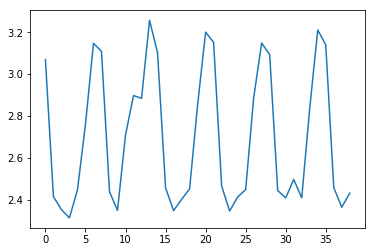

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.134126   
air_0164b9927d20bcc3_2017-04-23              1.371967   
air_0241aa3964b7f861_2017-04-23              2.222634   
air_0328696196e46f18_2017-04-23              2.267832   
air_034a3d5b40d5b1b1_2017-04-23              3.448725   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.449660  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.943099  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.231618  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   8.658442  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.460247

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')